# microCOSM Model ensemble

<img src="microCOSM_schematic.png" width="1200" />

The _microCOSM_ (micro-Carbon/Climate/Ocean Science Model) model has six boxes representing the Surface Atlantic (SA), Surface Southern (SS), Surface Pacific (SP), Deep Atlantic (DA), Deep Southern (DS), and Deep Pacific (DP) Oceans. (A) Two interconnected pathways of the largescale ocean circulation are represented:
Upwelling in the Southern Ocean (SUP) brings deep waters to the surface around Antarctica. These waters are then transported throughout the ocean in the Atlantic Meridional Overturning Circulation (AMOC), representing the path of North Atlantic Deep Waters, or the Southern Ocean Meridional Overturning Circulation (SMOC), representing the path of Antarctic Bottom Waters. (B) Transports between adjacent boxes are prescribed as a fraction of Southern Ocean upwelling (highlighted in white), which is varied over a wide range of values. AMOC transport is equivalent to Southern Ocean upwelling, although note that half of AMOC transport comes from the Surface Pacific, while SMOC is equivalent to 55% of Southern Ocean upwelling. Iron-binding ligands are produced by organic matter turnover, and lost by microbial degradation (Lauderdale et al, 2020, doi:10.1073/pnas.1917277117).

In this notebook we run two spin up simulations starting from arbitrary initial conditions and fixed atmospheric pCO$_2$ with fixed and dynamic ligands.



In [51]:
import glob              as gb
import matplotlib        as mp
import matplotlib.pyplot as plt
import numpy             as np
import numpy.ma          as nm
import pandas            as pd
import warnings          as ws


# Some figure options for later
mp.rcParams["xtick.labelsize"] = 14
mp.rcParams["ytick.labelsize"] = 14

def compile_microcosm(options=None):
    # Function to help compile the microCOSM box model
    # Supply compile options as a list of the following:
    #    FIXATMPCO2 - disable the conservative atmospheric carbon box
    #    WRITEOUTFILE - enable the textfile output.
    # NOTE: you have to restart the kernal if you change these options and recompile
    #       more than once...limitation of using f2py
    import os
    import subprocess

    # Depending on platform
    if os.sys.platform == "darwin":
        # Issue with compilation where f2py is linking to v10.9 rather than current OSX version.
        import platform

        mac_ver = ".".join(platform.mac_ver()[0].split(".")[:2])
        env = dict(os.environ, **{"MACOSX_DEPLOYMENT_TARGET": mac_ver})
        print("setting MACOSX_DEPLOYMENT_TARGET to: " + mac_ver)
    else:
        env = os.environ

    optdefs = "OPTIONDEFS = "
    if options is not None:
        optdefs = optdefs + " ".join(["-D" + item for item in options])
        print("Compiling with options: " + optdefs)
    # Clean environment of previous model files
    runmake = subprocess.Popen(
        ["make", "clean"],
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,
        env=env,
    )
    runmake.wait()
    # Compile 
    runmake = subprocess.Popen(
        ["make", "pymodel", optdefs],
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,
        env=env,
    )
    runmake.wait()
    print("The exit code for compilations was: %d" % runmake.returncode)
    return runmake.returncode

def get_ligand_parameters(fadd="",gamma_over_lambda=4398.0,gamma=5.0e-5,lig_conc=2.0,R_cp=106.0):
    if gamma_over_lambda > 0.0:
        # Assume this means prognostic ligand required
        fadd       = fadd + "variablelt"
        # Gamma over lambda for ligands "optimum" value (Lauderdale et al 2020)    
        # gamma input to the model is in phosphate units, not carbon units...
        # (also applies to gamma_over_lambda...lambda should be in 1/seconds)
        lig_gamma  = np.array((gamma * R_cp,))
        lig_lambda = 1.0 / ((lig_gamma / R_cp) / gamma_over_lambda)
        lig_conc   = 0.0
    else:
        fadd       = fadd + "fixedlt{0:1.0f}nm".format(lig_conc)
        lig_gamma  = np.array((0.0,))
        lig_lambda = np.array((0.0,))
    return fadd, lig_gamma, lig_lambda, lig_conc

SPUNUP = False


## 1. Model parameters and initial conditions

First, we want to compile the model with the correct flags:

In [52]:
ec = compile_microcosm(options=["FIXATMPCO2","SIXBOX"])

if ec == 0:
    import microCOSM

setting MACOSX_DEPLOYMENT_TARGET to: 12.5
Compiling with options: OPTIONDEFS = -DFIXATMPCO2 -DSIXBOX
The exit code for compilations was: 0


Set a few parameters. The geometry of the model set here *is* passed to the model routines, but you should edit `mod_dimensions.f90` and recompile to make structural changes to microCOSM, such as the number of boxes.

In [53]:
# Run for 100kyrs, with 100 year output
maxyears    = 1e5
outputyears = 1e2
outstepmax  = (maxyears/outputyears)+1 # this is the length of the output vectors/arrays

# Box names
names={"SA":"Surface Atlantic",
       "DA":"Deep Atlantic",
       "SS":"Surface Southern Ocean",
       "DS":"Deep Southern Ocean",
       "SP":"Surface Pacific",
       "DP":"Deep Pacific"}

# Geometry: Box dimensions (m), areas, volumes
dx = np.array([17.0e6, 17.0e6, 17.0e6, 17.0e6, 17.0e6, 17.0e6])
dy = np.array([ 4.0e6,  4.0e6,  2.0e6,  2.0e6,  8.0e6,  8.0e6])
dz = np.array([ 100.0, 3900.0,  100.0, 3900.0,  100.0, 3900.0])

# Provide centered depths of the boxes
depth = dz/2.0
depth[1] += dz[0]
depth[3] += dz[2]
depth[5] += dz[4]

# Provide central latitudes for the boxes                 
m2deg    = 180./(dy[2]/2+dy[4]) 
latitude = np.array((((dy[0]/2.0)+(dy[2]/2.0)),
                     ((dy[1]/2.0)+(dy[3]/2.0)),
                     ((dy[2]/2.0)            ),
                     ((dy[3]/2.0)            ),
                     ((dy[4]/2.0)+(dy[2]/2.0)),
                     ((dy[5]/2.0)+(dy[3]/2.0)),  
                    ))
latitude = -90.+latitude*m2deg
#latitude = np.array([0.0, 0.0, -70.0, -70.0, 0.0, 0.0])

# area/volume are recalculated by the model (but could be useful here)
area  = dx * dy
vol   = area * dz
invol = 1.0 / vol

# Rates of overturning circulation and mixing (Sv)
psi = np.array((20.0e6,)) 
dif = np.array(( 0.0e6,))

# define arrays (nbox*nbox long) of box connectivity for mixing and overturning (by columns)
# Box 1 mixes with box 2 and 3; 
# Box 2 mixes with box 1 and 4; 
# Box 3 mixes with box 1, 4 and 5; 
# Box 4 mixes with box 2, 3, and 6;
# Box 5 mixes with box 3 and 6;
# Box 6 mixes with box 4 and 5.
#                  Box1 Box2 Box3 Box4 Box5 Box6  
Kmix = [np.array([[ 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], # Box1
                  [ 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], # Box2
                  [ 1.0, 0.0, 0.0, 1.0, 1.0, 0.0], # Box3
                  [ 0.0, 1.0, 1.0, 0.0, 0.0, 1.0], # Box4
                  [ 0.0, 0.0, 1.0, 0.0, 0.0, 1.0], # Box5
                  [ 0.0, 0.0, 0.0, 1.0, 1.0, 0.0], # Box6
                 ])]    

# Box 1 is upstream of box 2; 
# Box 2 is upstream of box 1 and box 4; 
# Box 3 is upstream of box 1, 4, and 5; 
# Box 4 is upstream of box 2, 3, and 6;
# Box 5 is upstream of box 1 and box 6;
# Box 6 is upstream of box 4 and box 5.
#                  Box1  Box2  Box3  Box4  Box5  Box6  
Pcir = np.array([[ 0.00, 0.35, 0.15, 0.00, 0.50, 0.00], # Box1
                 [ 1.00, 0.00, 0.00, 0.25, 0.00, 0.00], # Box2
                 [ 0.00, 0.00, 0.00, 1.00, 0.00, 0.00], # Box3
                 [ 0.00, 0.90, 0.55, 0.00, 0.00, 0.90], # Box4
                 [ 0.00, 0.00, 0.30, 0.00, 0.00, 0.70], # Box5
                 [ 0.00, 0.00, 0.00, 1.10, 0.50, 0.00], # Box6
                ])

In [54]:
# Elemental stoichiometry
R_np = 16
R_cp = 106

# Biological production maximum rate per year (mol/kg/yr converted to mol/m3/s within the model)
alpha_yr = np.array((6e-6,))

# define array of remineralization coefficients (by column)
# -1 indicates all of export is lost from cell, while 
# +1 indicates all of export is remineralized (gained) by cell
#                     Box1  Box2  Box3  Box4  Box5  Box6  
Rremin = np.array([[ -1.0,  0.0,  0.0,  0.0,  0.0,  0.0], # Box1
                   [  1.0,  0.0,  0.0,  0.0,  0.0,  0.0], # Box2
                   [  0.0,  0.0, -1.0,  0.0,  0.0,  0.0], # Box3
                   [  0.0,  0.0,  1.0,  0.0,  0.0,  0.0], # Box4
                   [  0.0,  0.0,  0.0,  0.0, -1.0,  0.0], # Box5
                   [  0.0,  0.0,  0.0,  0.0,  1.0,  0.0], # Box6
                 
                  ])
# indicates Box 1 loses export from Box 1, which is completely remineralized in Box 3 (Box 2 is adjacent)
#           Box 2 loses export from Box 2, which is also completely remineralized in Box 3 (Box 1 is adjacent)
# If there are multiple boxes in the vertical, this would be the place 
#   to add a fractional vertical dependence (as long as columns add up to zero)

# Filename suffix
fadd = "6box"

# Iron input to each box (i.e. representing dust, sediment, or hydrothermal fluxes)
# Dust deposition in g Fe m-2 year-1 from Mahowald et al (2006)
# but there is a dependence on size of upper box because the model divides by dz to get 
# concentration tendency
fe_input = np.array([1.5e-1, 0.0, 1.5e-3, 0.0, 1.5e-2, 0.0])*(dz[0]/50)
# Hydrothermal vent input of 1 Gmol/yr (Tagliabue et al., 2010)
# mol Fe/yr * g/mol * 1/area  == g Fe m-2 year-1....
# divide by 2.5e-3 because fe_sol=2.5e-3 is multiplied again within the box model.
vent_iron_source = (1e9 * 56) / (2.5e-3 * np.sum(area[[1,3,5]]))
fe_input[1] = vent_iron_source * (area[1] / np.sum(area[[1,3,5]]))
fe_input[3] = vent_iron_source * (area[3] / np.sum(area[[1,3,5]]))
fe_input[5] = vent_iron_source * (area[5] / np.sum(area[[1,3,5]]))

# Fixed value for uniform ligand control experiment
fadd, lig_gamma, lig_lambda, lig_conc = get_ligand_parameters(fadd, gamma_over_lambda=0.0, gamma=0.0, lig_conc=2.0, R_cp=106.0)

# Deep ocean box lifetime modifier - capture the gradient introduced by photodegradation near the surface and slower loss in the deep ocean
dlambdadz = np.array([1.0, 0.01, 1.0, 0.01, 1.0, 0.01])

# For air sea exchange of CO2 we need wind speed and the open ocean fraction (ie sea-ice cover or deep ocean)
wind  = np.array([5.0, 0.0, 10.0, 0.0, 5.0, 0.0])
fopen = np.array([1.0, 0.0, 1.0,  0.0, 1.0, 0.0])

# Typical concentrations, etc
theta = np.array((20.00,  4.00, -1.0,  -1.00, 20.00,  4.00))
salt  = np.array((35.50, 35.50, 34.75, 34.75, 35.00, 35.00))

if SPUNUP is True:
    # Here are some equilibrated initial concentrations in (u/n)mol/kg
    # run for 100,000 yrs (round-off error notwithstanding)
    # Make sure to compile without -DFIXATMPCO2
    carbon     = np.array((2262.975612, 2102.979876, 2363.978019))
    alkalinity = np.array((2395.675115, 2387.423546, 2399.113996))
    phosphate  = np.array((   1.837220, 0.250380   ,    2.498544))
    nitrate    = np.array((  25.434742, 0.045298   ,   36.015914))
    iron       = np.array((   0.010337, 0.329535   ,    0.574288))
    ligand     = np.array((   1.664667, 1.631715   ,    1.625804))
#    carbon     = np.array((2264.67564, 2103.48757, 2364.66971))
#    alkalinity = np.array((2395.54471, 2387.42965, 2399.11941))
#    phosphate  = np.array((   1.81089,    0.25031,    2.49834))
#    nitrate    = np.array((  25.01353,    0.04412,   36.01262))
#    iron       = np.array((   0.00377,    0.49776,    0.58847))
#    ligand     = np.array((   2.08548,    1.56387,    1.62029))
    atmpco2    = np.array(( 280.00000,))
else:
    # Here are some typical initial concentrations in (u/n)mol/kg
    # Make sure to compile with -DFIXATMPCO2 first
    carbon     = np.array((2100.0, 2400.0, 2100.0, 2400.0, 2100.0, 2400.0))
    alkalinity = np.array((2350.0, 2400.0, 2300.0, 2400.0, 2300.0, 2400.0))
    phosphate  = np.array((   0.0,    2.0,    2.0,    2.0,    0.0,    2.5))
    nitrate    = np.array((   0.0,   30.0,   30.0,   30.0,    0.0,   36.0))
    iron       = np.array((   0.0,    0.0,    0.0,    0.0,    0.0,    0.0))
    ligand     = np.ones ((len(dz),)) * lig_conc
    atmpco2    = np.array((280.00000,))

Create a consolidated Pandas dataframe with the input values to feed into the model

In [55]:
fixedlig_input = dict()
fixedlig_parms = dict()
fixedlig_output= dict()

time = pd.DataFrame({
         "niter": int(1),
         "nyrs" : maxyears,
         "tout" : outputyears,
         "nout" : int(outstepmax),
           },index=[0])

parm = pd.DataFrame({
         "dx"        : [dx],
         "dy"        : [dy],
         "dz"        : [dz],
         "depth"     : [depth],
         "latitude"  : [latitude],
         "Kmix"      : [Kmix],
         "Rremin"    : [Rremin],
         "Pcir"      : [Pcir],
         "psi"       : psi,
         "dif"       : dif,
         "alphabio"  : alpha_yr,
         "gamma"     : lig_gamma,
         "lambda"    : lig_lambda,
         "dlambdadz" : [dlambdadz],
         "sourceFe"  : [fe_input],
         "wind"      : [wind],
         "fopen"     : [fopen],
                 })

data = pd.DataFrame({
         "theta"     : [theta],
         "salt"      : [salt],
         "carbon"    : [carbon],
         "alkalinity": [alkalinity],
         "phosphate" : [phosphate],
         "nitrate"   : [nitrate],
         "iron"      : [iron],
         "ligand"    : [ligand],
         "atmpco2"   : atmpco2,
                  })

fixedlig_parms['cntrl'] = parm
fixedlig_input['cntrl'] = pd.concat((time, parm, data), axis=1)
fixedlig_input['cntrl']

,niter,nyrs,tout,nout,dx,dy,dz,depth,latitude,Kmix,...,fopen,theta,salt,carbon,alkalinity,phosphate,nitrate,iron,ligand,atmpco2
0,1,100000.0,100.0,1001,"[17000000.0, 17000000.0, 17000000.0, 17000000....","[4000000.0, 4000000.0, 2000000.0, 2000000.0, 8...","[100.0, 3900.0, 100.0, 3900.0, 100.0, 3900.0]","[50.0, 2050.0, 50.0, 2050.0, 50.0, 2050.0]","[-29.999999999999993, -29.999999999999993, -70...","[[[0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0...",...,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0]","[20.0, 4.0, -1.0, -1.0, 20.0, 4.0]","[35.5, 35.5, 34.75, 34.75, 35.0, 35.0]","[2100.0, 2400.0, 2100.0, 2400.0, 2100.0, 2400.0]","[2350.0, 2400.0, 2300.0, 2400.0, 2300.0, 2400.0]","[0.0, 2.0, 2.0, 2.0, 0.0, 2.5]","[0.0, 30.0, 30.0, 30.0, 0.0, 36.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0]",280.0


### 2. Call the model from the _microCOSM_ package and capture the output in a pandas dataframe 

In [6]:
fixedlig_output['cntrl'] = pd.DataFrame( 
                                np.column_stack(
                                   microCOSM.mod_modelmain.model(
                                          *[fixedlig_input['cntrl'][io][0] for io in fixedlig_input['cntrl'].columns]
                                                                ),
                                          ).T,
                                   index=["time"]\
                                        +["t" + name.lower() for name in names]\
                                        +["s" + name.lower() for name in names]\
                                        +["c" + name.lower() for name in names]\
                                        +["a" + name.lower() for name in names]\
                                        +["p" + name.lower() for name in names]\
                                        +["n" + name.lower() for name in names]\
                                        +["f" + name.lower() for name in names]\
                                        +["l" + name.lower() for name in names]\
                                        +["export" + name.lower() for name in names]\
                                        +["lim"]\
                                        +["pstar"]\
                                        +["pco2" + name.lower() for name in names]\
                                        +["atmpco2"],
                                  ).transpose()

# output array such that it could be used to restart the next simulation
pd.concat(
    [
        time.iloc[0],
        fixedlig_parms['cntrl'].iloc[0],
        pd  .Series({
              "theta"     : fixedlig_output['cntrl'][["t" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "salt"      : fixedlig_output['cntrl'][["s" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "carbon"    : fixedlig_output['cntrl'][["c" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "alkalinity": fixedlig_output['cntrl'][["a" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "phosphate" : fixedlig_output['cntrl'][["p" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "nitrate"   : fixedlig_output['cntrl'][["n" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "iron"      : fixedlig_output['cntrl'][["f" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "ligand"    : fixedlig_output['cntrl'][["l" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "atmpco2"   : fixedlig_output['cntrl']['atmpco2'].iloc[-1],
                  }),
    ]
).transpose().to_json("run_microCOSM_" + fadd + "_pickup.json")

## 3. Plot the model timeseries

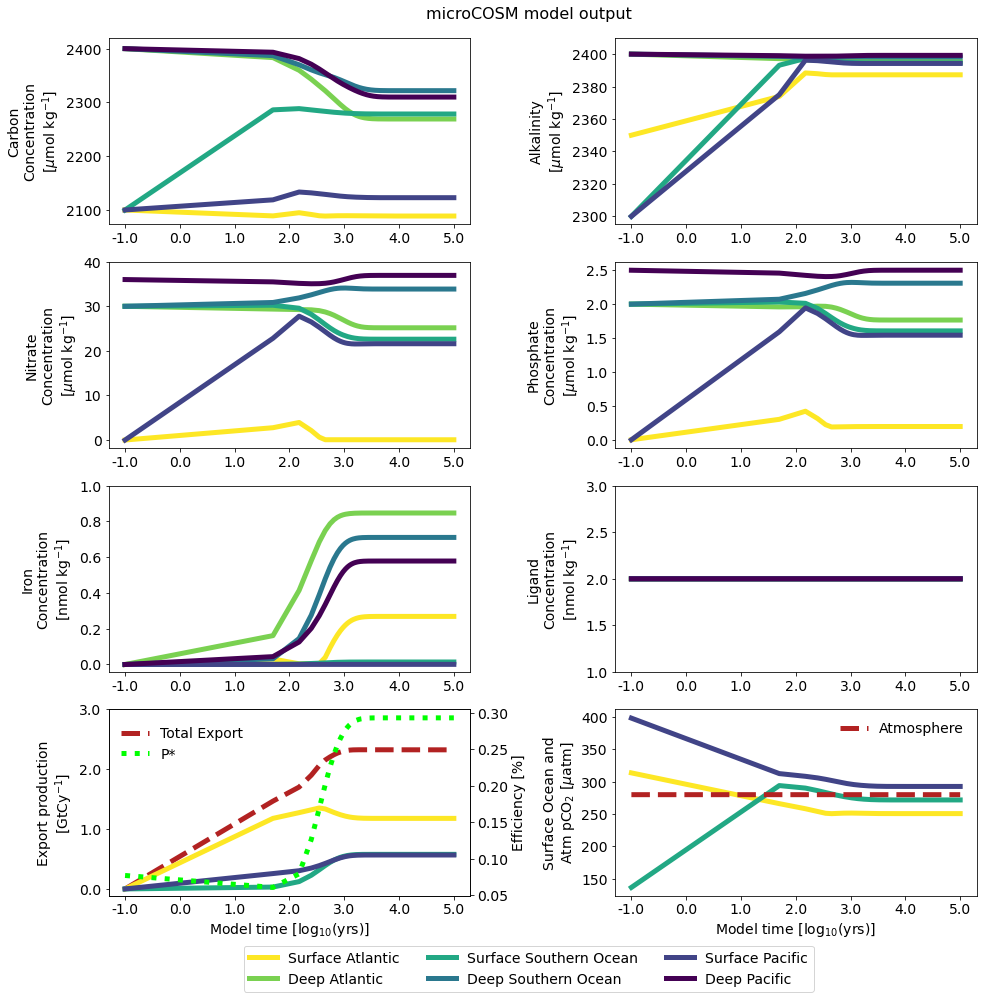

In [7]:
# Make sure initial conditions are included at t~0
fixedlig_output['cntrl'].at[0, "time"] = 1e-1

# Integrated export production
fixedlig_output['cntrl']["exp"] = fixedlig_output['cntrl']["exportsa"] + fixedlig_output['cntrl']["exportss"] + fixedlig_output['cntrl']["exportsp"]

# Plot the timeseries of...
from matplotlib.ticker import FormatStrFormatter

len_xaxis, len_yaxis = 4, 4  # fix here your numbers
xspace, yspace = 0.9, 0.9  # change the size of the void border here.
x_fig, y_fig = len_xaxis / xspace, len_yaxis / yspace

f1, f1ax = plt.subplots(figsize=(3.5 * x_fig, 3.25 * y_fig), ncols=2, nrows=4)
f1.patch.set_facecolor("None")
mycm = plt.cm.get_cmap("viridis_r")

# ...Carbon and Alkalinity
for ii,name in enumerate(names):
    f1ax[0, 0].plot(
        np.log10(fixedlig_output['cntrl']["time"]),
        fixedlig_output['cntrl']["c"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f1ax[0, 0].set_ylim(top=np.ceil(np.max(f1ax[0, 0].get_ylim()) / 10) * 10)
f1ax[0, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[0, 0].set_ylabel("Carbon\nConcentration\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii,name in enumerate(names):
    f1ax[0, 1].plot(
        np.log10(fixedlig_output['cntrl']["time"]),
        fixedlig_output['cntrl']["a"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f1ax[0, 1].set_ylim(top=np.ceil(np.max(f1ax[0, 1].get_ylim()) / 10) * 10)
f1ax[0, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[0, 1].set_ylabel("Alkalinity\n[$\mu$mol kg$^{-1}$]", fontsize=14)

# ...Macronutrients
for ii,name in enumerate(names):
    f1ax[1, 0].plot(
        np.log10(fixedlig_output['cntrl']["time"]),
        fixedlig_output['cntrl']["n"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f1ax[1, 0].set_ylim(top=np.ceil(np.max(f1ax[1, 0].get_ylim()) / 10) * 10)
f1ax[1, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[1, 0].set_ylabel("Nitrate\nConcentration\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii,name in enumerate(names):
    f1ax[1, 1].plot(
        np.log10(fixedlig_output['cntrl']["time"]),
        fixedlig_output['cntrl']["p"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f1ax[1, 1].set_xlim(left=np.min(f1ax[1, 0].get_xlim()))
f1ax[1, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[1, 1].set_ylabel("Phosphate\nConcentration\n[$\mu$mol kg$^{-1}$]", fontsize=14)

# ...Iron/Ligands
for ii,name in enumerate(names):
    f1ax[2, 0].plot(
        np.log10(fixedlig_output['cntrl']["time"]),
        fixedlig_output['cntrl']["f"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f1ax[2, 0].set_ylim(top=np.ceil(np.max(f1ax[2, 0].get_ylim())))
f1ax[2, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[2, 0].set_ylabel("Iron\nConcentration\n[nmol kg$^{-1}$]", fontsize=14)

for ii,name in enumerate(names):
    f1ax[2, 1].plot(
        np.log10(fixedlig_output['cntrl']["time"]),
        fixedlig_output['cntrl']["l"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f1ax[2, 1].set_ylim(top=np.ceil(np.max(f1ax[2, 1].get_ylim())),
                 bottom=np.max([0.0,lig_conc-1.0]))
f1ax[2, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[2, 1].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[2, 1].set_ylabel("Ligand\nConcentration\n[nmol kg$^{-1}$]", fontsize=14)

# ...Export/pstar
# Total
f1ax[3, 0].plot(
    np.log10(fixedlig_output['cntrl']["time"]),
    fixedlig_output['cntrl']["exp"],
    color="firebrick",
    linewidth=5,
    linestyle="--",
    label="Total Export",
)
for ii,name in enumerate(names):
    if name in ["SA","SS","SP"]:     
        f1ax[3, 0].plot(
            np.log10(fixedlig_output['cntrl']["time"]),
            fixedlig_output['cntrl']["export"+name.lower()],
            color=mycm(ii/(len(names)-1)),
            linewidth=5,
            #label=names[name],
        )
# PS
f1ax30b = f1ax[3, 0].twinx()
f1ax30b.plot(
    np.log10(fixedlig_output['cntrl']["time"]),
    fixedlig_output['cntrl']["pstar"],
    color="lime",
    linewidth=5,
    linestyle=":",
    label="P*",
)
f1ax[3, 0].legend(
    loc="upper left",
    bbox_to_anchor=(0.125, 0.30),
    bbox_transform=f1.transFigure,
    frameon=False,
    fontsize=14,
)
f1ax30b.legend(
    loc="upper left",
    bbox_to_anchor=(0.125, 0.28),
    bbox_transform=f1.transFigure,
    frameon=False,
    fontsize=14,
)
f1ax[3, 0].set_ylim(top=np.ceil(np.max(f1ax[3, 0].get_ylim())))
f1ax[3, 0].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[3, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[3, 0].set_ylabel("Export production\n[GtCy$^{-1}$]", fontsize=14)
f1ax30b.   set_ylabel("Efficiency [%]", fontsize=14)
f1ax[3, 0].set_xlabel("Model time [log$_{10}$(yrs)]", fontsize=14)

# ...pCO2
for ii,name in enumerate(names):
    if name in ["SA","SS","SP"]:
        f1ax[3, 1].plot(
            np.log10(fixedlig_output['cntrl']["time"]),
            fixedlig_output['cntrl']["pco2"+name.lower()],
            color=mycm(ii/(len(names)-1)),
            linewidth=5,
            #label=names[name],
        )
# ATM
f1ax[3, 1].plot(
    np.log10(fixedlig_output['cntrl']["time"]),
    fixedlig_output['cntrl']["atmpco2"],
    color='firebrick',
    linewidth=5,
    linestyle="--",
    label="Atmosphere",
)
f1ax[3, 1].legend(frameon=False, fontsize=14)
f1ax[3, 1].set_ylim(top=np.ceil(np.max(f1ax[3, 1].get_ylim())))
f1ax[3, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[3, 1].set_ylabel("Surface Ocean and\nAtm pCO$_2$ [$\mu$atm]", fontsize=14)
f1ax[3, 1].set_xlabel("Model time [log$_{10}$(yrs)]", fontsize=14)

# Add global box legend at the bottom
f1ax[0, 0].legend(
    frameon=True, 
    fontsize=14, 
    ncol=int(len(dz)/2), 
    loc='center', 
    bbox_transform=f1.transFigure,bbox_to_anchor=(0.5, 0.055))

plt.suptitle("microCOSM model output", fontsize=16)
# Can adjust the subplot size
plt.subplots_adjust(wspace=0.4, top=0.95)
plt.show()

# save the graph
f1.savefig(
    "microCOSM_" + fadd + "_spinup.pdf",
    format="pdf",
    facecolor=f1.get_facecolor(),
    edgecolor="none",
    bbox_inches="tight",
)
plt.close()

## 4. Change gamma/lambda and gamma for variable ligand control experiment

In [56]:
variablelig_input = dict()
variablelig_parms = dict()
variablelig_output= dict()

variablelig_input['cntrl'] = fixedlig_input['cntrl'].copy()
variablelig_parms['cntrl'] = fixedlig_parms['cntrl'].copy()

fadd, lig_gamma, lig_lambda, lig_conc = get_ligand_parameters(fadd='6box',gamma_over_lambda=4398.0,gamma=5.0e-5,lig_conc=2.0,R_cp=106.0)

variablelig_input['cntrl']['gamma']  = lig_gamma
variablelig_parms['cntrl']['gamma']  = lig_gamma
variablelig_input['cntrl']['lambda'] = lig_lambda
variablelig_parms['cntrl']['lambda'] = lig_lambda
variablelig_input['cntrl']['ligand'] = pd.Series([np.ones ((len(dz),)) * lig_conc])

In [10]:
variablelig_output['cntrl'] = pd.DataFrame( 
                np.column_stack(
                   microCOSM.mod_modelmain.model(
                          *[variablelig_input['cntrl'][io][0] for io in variablelig_input['cntrl'].columns]
                                                ),
                          ).T,
                   index=["time"]\
                        +["t" + name.lower() for name in names]\
                        +["s" + name.lower() for name in names]\
                        +["c" + name.lower() for name in names]\
                        +["a" + name.lower() for name in names]\
                        +["p" + name.lower() for name in names]\
                        +["n" + name.lower() for name in names]\
                        +["f" + name.lower() for name in names]\
                        +["l" + name.lower() for name in names]\
                        +["export" + name.lower() for name in names]\
                        +["lim"]\
                        +["pstar"]\
                        +["pco2" + name.lower() for name in names]\
                        +["atmpco2"],
                  ).transpose()

# output array such that it could be used to restart the next simulation
pd.concat(
    [
        time.iloc[0],
        variablelig_parms['cntrl'].iloc[0],
        pd  .Series({
              "theta"     : variablelig_output['cntrl'][["t" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "salt"      : variablelig_output['cntrl'][["s" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "carbon"    : variablelig_output['cntrl'][["c" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "alkalinity": variablelig_output['cntrl'][["a" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "phosphate" : variablelig_output['cntrl'][["p" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "nitrate"   : variablelig_output['cntrl'][["n" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "iron"      : variablelig_output['cntrl'][["f" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "ligand"    : variablelig_output['cntrl'][["l" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "atmpco2"   : variablelig_output['cntrl']['atmpco2'].iloc[-1],
                  }),
    ]
).transpose().to_json("run_microCOSM_" + fadd + "_pickup.json")

## 5. Plot the model timeseries

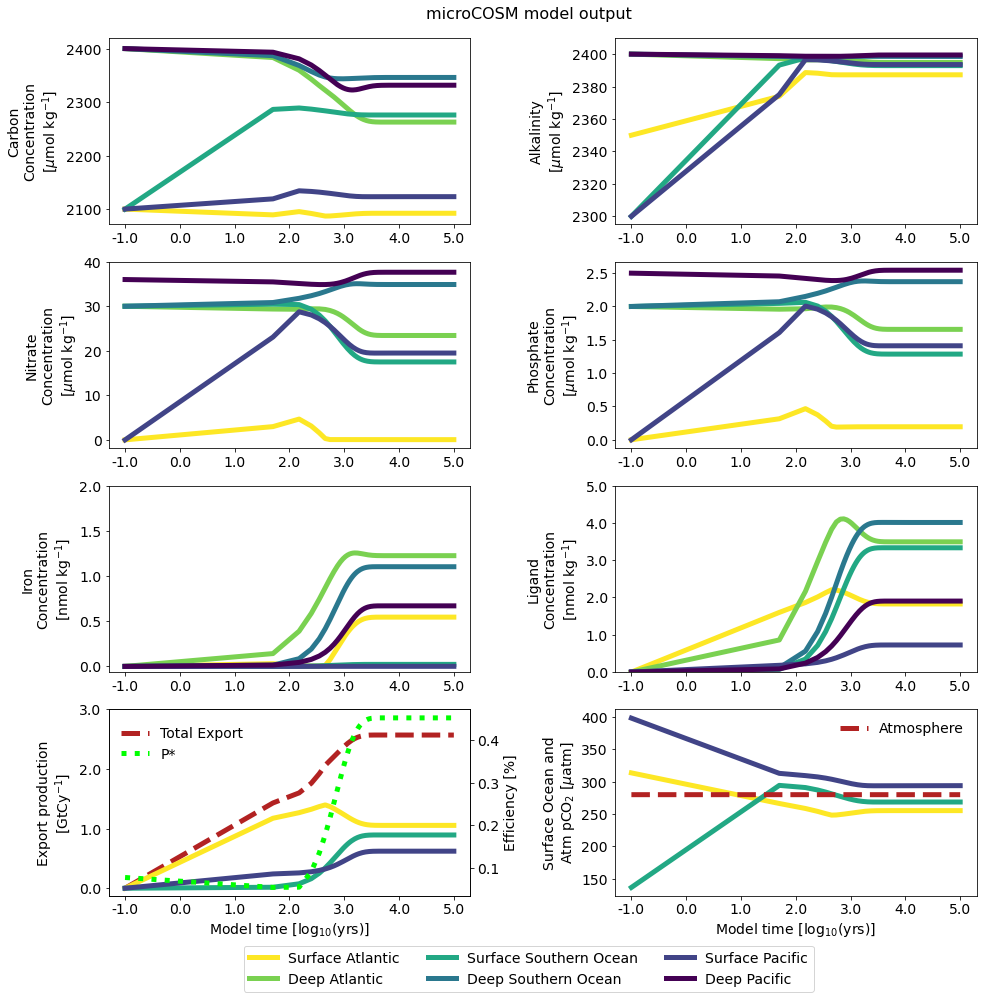

In [11]:
# Make sure initial conditions are included at t~0
variablelig_output['cntrl'].at[0, "time"] = 1e-1

# Integrated export production
variablelig_output['cntrl']["exp"] = variablelig_output['cntrl']["exportsa"] + variablelig_output['cntrl']["exportss"] + variablelig_output['cntrl']["exportsp"]

# Plot the timeseries of...
from matplotlib.ticker import FormatStrFormatter

len_xaxis, len_yaxis = 4, 4  # fix here your numbers
xspace, yspace = 0.9, 0.9  # change the size of the void border here.
x_fig, y_fig = len_xaxis / xspace, len_yaxis / yspace

f2, f2ax = plt.subplots(figsize=(3.5 * x_fig, 3.25 * y_fig), ncols=2, nrows=4)
f2.patch.set_facecolor("None")
mycm = plt.cm.get_cmap("viridis_r")

# ...Carbon and Alkalinity
for ii,name in enumerate(names):
    f2ax[0, 0].plot(
        np.log10(variablelig_output['cntrl']["time"]),
        variablelig_output['cntrl']["c"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f2ax[0, 0].set_ylim(top=np.ceil(np.max(f2ax[0, 0].get_ylim()) / 10) * 10)
f2ax[0, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[0, 0].set_ylabel("Carbon\nConcentration\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii,name in enumerate(names):
    f2ax[0, 1].plot(
        np.log10(variablelig_output['cntrl']["time"]),
        variablelig_output['cntrl']["a"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f2ax[0, 1].set_ylim(top=np.ceil(np.max(f2ax[0, 1].get_ylim()) / 10) * 10)
f2ax[0, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[0, 1].set_ylabel("Alkalinity\n[$\mu$mol kg$^{-1}$]", fontsize=14)

# ...Macronutrients
for ii,name in enumerate(names):
    f2ax[1, 0].plot(
        np.log10(variablelig_output['cntrl']["time"]),
        variablelig_output['cntrl']["n"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f2ax[1, 0].set_ylim(top=np.ceil(np.max(f2ax[1, 0].get_ylim()) / 10) * 10)
f2ax[1, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[1, 0].set_ylabel("Nitrate\nConcentration\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii,name in enumerate(names):
    f2ax[1, 1].plot(
        np.log10(variablelig_output['cntrl']["time"]),
        variablelig_output['cntrl']["p"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f2ax[1, 1].set_xlim(left=np.min(f2ax[1, 0].get_xlim()))
f2ax[1, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[1, 1].set_ylabel("Phosphate\nConcentration\n[$\mu$mol kg$^{-1}$]", fontsize=14)

# ...Iron/Ligands
for ii,name in enumerate(names):
    f2ax[2, 0].plot(
        np.log10(variablelig_output['cntrl']["time"]),
        variablelig_output['cntrl']["f"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f2ax[2, 0].set_ylim(top=np.ceil(np.max(f2ax[2, 0].get_ylim())))
f2ax[2, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[2, 0].set_ylabel("Iron\nConcentration\n[nmol kg$^{-1}$]", fontsize=14)

for ii,name in enumerate(names):
    f2ax[2, 1].plot(
        np.log10(variablelig_output['cntrl']["time"]),
        variablelig_output['cntrl']["l"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f2ax[2, 1].set_ylim(top=np.ceil(np.max(f2ax[2, 1].get_ylim())),
                 bottom=np.max([0.0,lig_conc-1.0]))
f2ax[2, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[2, 1].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[2, 1].set_ylabel("Ligand\nConcentration\n[nmol kg$^{-1}$]", fontsize=14)

# ...Export/pstar
# Total
f2ax[3, 0].plot(
    np.log10(variablelig_output['cntrl']["time"]),
    variablelig_output['cntrl']["exp"],
    color="firebrick",
    linewidth=5,
    linestyle="--",
    label="Total Export",
)
for ii,name in enumerate(names):
    if name in ["SA","SS","SP"]:     
        f2ax[3, 0].plot(
            np.log10(variablelig_output['cntrl']["time"]),
            variablelig_output['cntrl']["export"+name.lower()],
            color=mycm(ii/(len(names)-1)),
            linewidth=5,
            #label=names[name],
        )
# PS
f2ax30b = f2ax[3, 0].twinx()
f2ax30b.plot(
    np.log10(variablelig_output['cntrl']["time"]),
    variablelig_output['cntrl']["pstar"],
    color="lime",
    linewidth=5,
    linestyle=":",
    label="P*",
)
f2ax[3, 0].legend(
    loc="upper left",
    bbox_to_anchor=(0.125, 0.30),
    bbox_transform=f2.transFigure,
    frameon=False,
    fontsize=14,
)
f2ax30b.legend(
    loc="upper left",
    bbox_to_anchor=(0.125, 0.28),
    bbox_transform=f2.transFigure,
    frameon=False,
    fontsize=14,
)
f2ax[3, 0].set_ylim(top=np.ceil(np.max(f2ax[3, 0].get_ylim())))
f2ax[3, 0].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[3, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[3, 0].set_ylabel("Export production\n[GtCy$^{-1}$]", fontsize=14)
f2ax30b.   set_ylabel("Efficiency [%]", fontsize=14)
f2ax[3, 0].set_xlabel("Model time [log$_{10}$(yrs)]", fontsize=14)

# ...pCO2
for ii,name in enumerate(names):
    if name in ["SA","SS","SP"]:     
        f2ax[3, 1].plot(
            np.log10(variablelig_output['cntrl']["time"]),
            variablelig_output['cntrl']["pco2"+name.lower()],
            color=mycm(ii/(len(names)-1)),
            linewidth=5,
            #label=names[name],
        )
# ATM
f2ax[3, 1].plot(
    np.log10(variablelig_output['cntrl']["time"]),
    variablelig_output['cntrl']["atmpco2"],
    color='firebrick',
    linewidth=5,
    linestyle="--",
    label="Atmosphere",
)
f2ax[3, 1].legend(frameon=False, fontsize=14)
f2ax[3, 1].set_ylim(top=np.ceil(np.max(f2ax[3, 1].get_ylim())))
f2ax[3, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[3, 1].set_ylabel("Surface Ocean and\nAtm pCO$_2$ [$\mu$atm]", fontsize=14)
f2ax[3, 1].set_xlabel("Model time [log$_{10}$(yrs)]", fontsize=14)

# Add global box legend at the bottom
f2ax[0, 0].legend(
    frameon=True, 
    fontsize=14, 
    ncol=int(len(dz)/2), 
    loc='center', 
    bbox_transform=f2.transFigure,bbox_to_anchor=(0.5, 0.055),
)

plt.suptitle("microCOSM model output", fontsize=16)
# Can adjust the subplot size
plt.subplots_adjust(wspace=0.4, top=0.95)
plt.show()

# save the graph
f2.savefig(
    "microCOSM_" + fadd + "_spinup_timeseries.pdf",
    format="pdf",
    facecolor=f2.get_facecolor(),
    edgecolor="none",
    bbox_inches="tight",
)
plt.close()

## 6. Now go to the next notebook to run the MOC ensemble experiments